# 1. Load Data (Playground-series-s3e11 : Kaggle Competition)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# K-fold(CV), partial
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning - optuna
import optuna


In [ ]:
train = pd.read_csv('../input/playground-series-s3e11/train.csv', encoding='cp949')
test = pd.read_csv('../input/playground-series-s3e11/test.csv', encoding='cp949')
sample_submission = pd.read_csv('../input/playground-series-s3e11/sample_submission.csv', encoding='cp949')



# 2. EDA


In [ ]:
# Analyzing data 
print(train.info(),test.info(),sample_submission.info())
display(train.head(),sample_submission.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


,id,cost
240219,600555,99.615
240220,600556,99.615
240221,600557,99.615
240222,600558,99.615
240223,600559,99.615


In [ ]:
# Analyzing : feature <-> value correlation
df = train.copy()
df.corr()['cost'].sort_values(ascending = False) # List in order of correlation (descending order)
# targetvalue == cost

cost                          1.000000
avg_cars_at home(approx).1    0.027098
units_per_case                0.000180
gross_weight                 -0.000116
id                           -0.000611
recyclable_package           -0.001455
num_children_at_home         -0.001727
low_fat                      -0.001975
total_children               -0.007482
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
store_sqft                   -0.049201
coffee_bar                   -0.052086
salad_bar                    -0.098810
prepared_food                -0.098843
video_store                  -0.106786
florist                      -0.110414
Name: cost, dtype: float64

<Axes: >

['id',
 'store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'cost']

17

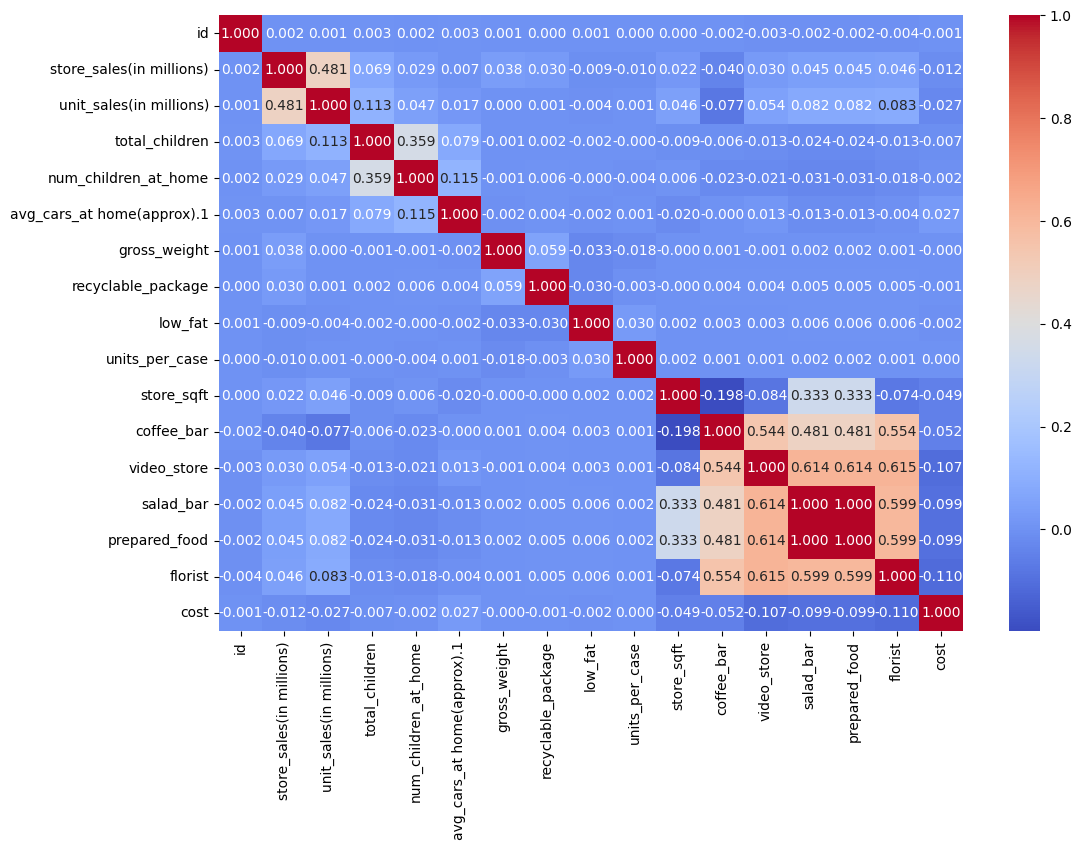

In [ ]:
# Analyzing : correlation all
plt.figure(figsize = (12,8)) # map size


display(sns.heatmap(df.corr(), annot = True, fmt='.3f', cmap='coolwarm'))

# Columns list
col_list = list(df.columns)
display(col_list,len(col_list))

# store_sales(in millions) == unit_sales(in millions) : same --> delete one of them


## VIF (Variance Inflation Factor)
- 분산 팽창 인수. 다중회귀분석에서 독립변수가 다중 공산성(Multicollnearity)의 문제를 갖고 있는지 판단하는 기준.
- 주로 10보다 크면 그 독립변수는 다중공산성이 있다.

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import statsmodels.api as sm

In [ ]:
# 변수 이름 변경
train_2 = train.copy()

# 특수문자 . 오류방지
train_2 = train_2.rename(columns={
    'store_sales(in millions)' : 'store_sales',
    'unit_sales(in millions)' : 'unit_sales',
    'avg_cars_at home(approx).1': 'avg_cars_at_home_approx_1'
})

display(train_2)

model = ols(
    'cost ~ store_sales + unit_sales + total_children + num_children_at_home + avg_cars_at_home_approx_1 + \
    gross_weight + recyclable_package + low_fat + units_per_case + store_sqft + coffee_bar + video_store + salad_bar + \
    prepared_food + florist', train_2
)
res = model.fit()
res.summary()

vdf = train_2[['store_sales', 'unit_sales', 'total_children', 'num_children_at_home',
       'avg_cars_at_home_approx_1', 'gross_weight', 'recyclable_package', 'low_fat',
       'units_per_case', 'store_sqft', 'coffee_bar', 'video_store',
       'salad_bar', 'prepared_food', 'florist', 'cost']]
        
vif_df = pd.DataFrame()
vif_df['feature'] = vdf.columns
vif_df['VIF'] = [VIF(vdf.values, i) for i in range(len(vdf.columns))]
vif_df



,id,store_sales,unit_sales,total_children,num_children_at_home,avg_cars_at_home_approx_1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


,feature,VIF
0,store_sales,6.099953
1,unit_sales,18.638599
2,total_children,4.269990
3,num_children_at_home,1.531726
4,avg_cars_at_home_approx_1,5.008708
5,gross_weight,8.986631
6,recyclable_package,2.301399
7,low_fat,1.481205
8,units_per_case,4.277325
9,store_sqft,20.718601


- salad_bar, prepared_food : VIF수치 매우 높음 -> 다중공선성 O -> Drop!

# 3. Feature Importance
- Importance between Target Values and Features

In [ ]:
# MI Score : Feature Importance between Target Values and Features
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# 'cost' 컬럼을 제외한 컬럼 리스트 생성
x_cols = [col for col in col_list if col != 'cost']

x_m = df[x_cols]
y_m = df['cost']

# Add columns : For test
x_m['with_children'] = x_m['total_children'] - x_m['num_children_at_home']
x_m['Facilities Sum'] = x_m['florist'] + x_m['prepared_food'] + x_m['coffee_bar'] + x_m['video_store']

# MI Score 계산
mi_scores = mutual_info_regression(x_m, y_m)
mi_scores = pd.Series(mi_scores, name = 'MI Scores', index=x_m.columns).sort_values(ascending=False)

print(mi_scores)


# 4. feature engineering



In [ ]:
# Add columns
df['with_children'] = df['total_children'] - df['num_children_at_home']
df['Facilities Sum'] = df['florist'] + df['prepared_food'] + df['coffee_bar'] + df['video_store']

categorical_cols = [
    'recyclable_package',
    'low_fat',
    'coffee_bar',
    'video_store',
    'salad_bar',
    'prepared_food',
    'florist',
    'total_children',
    'num_children_at_home',
    'avg_cars_at home(approx).1',
    'with_children',
    'Facilities Sum'
    ]
numerical_cols = [
    'store_sales(in millions)',
    'unit_sales(in millions)',
    'gross_weight',
    'units_per_case',
    'store_sqft',
    'with_children'  # Add column
    ]

# Drop numerical_cols : Except high importance features ('store_sqft')
drop_cols = [
    'cost', # target value
    'salad_bar', # same prepared_food : multicollinearity (다중공선성)
    'id', # useless
    'store_sales(in millions)', # numeric
    'unit_sales(in millions)', # numeric
    'gross_weight', # numeric
    'units_per_case', # numeric
    'recyclable_package', # categoric but low importance
    'low_fat' # categoric but low importance
    ] # + numerical_cols

features = [ i for i in df.columns if i not in drop_cols ]# except 'cost'
target_value = ['cost']
train = df.copy()

display(features)
display(train[features])

# Null counts
null_counts = df.isnull().sum()
print("Null 값의 갯수:")
print(null_counts)

# Remove Nagative value's line
negative_index = df[df.select_dtypes(include=[np.number]).lt(0).any(axis=1)].index
df = df.drop(negative_index, axis=0)
negative_counts = (df < 0).sum()
print("\n음수 값의 갯수:")
print(negative_counts)

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'prepared_food',
 'florist',
 'with_children',
 'Facilities Sum']

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,prepared_food,florist,with_children,Facilities Sum
0,2.0,2.0,2.0,36509.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,3.0,28206.0,1.0,0.0,0.0,0.0,4.0,1.0
2,0.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,0.0,1.0
3,5.0,0.0,0.0,21215.0,1.0,0.0,0.0,0.0,5.0,1.0
4,5.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...
360331,5.0,5.0,3.0,30268.0,0.0,0.0,0.0,0.0,0.0,0.0
360332,4.0,0.0,4.0,20319.0,0.0,0.0,0.0,0.0,4.0,0.0
360333,0.0,0.0,2.0,30584.0,1.0,1.0,1.0,1.0,0.0,4.0
360334,1.0,0.0,3.0,30584.0,1.0,1.0,1.0,1.0,1.0,4.0


Null 값의 갯수:
id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
with_children                 0
Facilities Sum                0
dtype: int64

음수 값의 갯수:
id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coff

# 5. model select and learning

LGBM, XGBoost, CatBoost, Ridge, Adaboost, KNN

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier, XGBRegressor
import xgboost as xgb
from lightgbm.sklearn import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import Pool

import optuna
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [ ]:

org_model_dict = {
    "LGBM": LGBMRegressor(),
    "XGB" : XGBRegressor(),
    "Cat": CatBoostRegressor(verbose=0),
    "ridge" : Ridge(),
    "Adaboost": AdaBoostRegressor()
#    "KNN": KNeighborsRegressor()
}

# Data Split ( Train : Varidation = 7 : 3 )
x = train[features]
y = train[target_value]
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = 42)

## LightGBM Regressor()

In [ ]:
# model - 1

# x = train.drop(columns= drop_list)
x = train[features]
y = train[target_value]

# Data Split => train 0.7 : validation 0.3
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = 42)


print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
model = LGBMRegressor() # highper parameter = default

print("\nFitting LightGBM...")
model_LGBM = model.fit(x_train, y_train)

print("\nModel learning completed !!!")


## XGBoost Regressor()

In [ ]:
# model - 2
model2 = XGBRegressor()

print("\nFitting XGBoost...")
model_XGB = model2.fit(x_train, y_train)
print("\nModel 2 learning completed !!!")

## CatBoost

In [ ]:
# model - 3
model_Cat = CatBoostRegressor()

print("\nFitting CatBoost...")
model_Cat.fit(x_train, y_train)
print("\nModel 3 learning completed !!!")

## Ridge & Lasso

In [ ]:
# model - 4
model_ridge = Ridge()

print("\nFitting Ridge...")
model_ridge.fit(x_train, y_train)
print("\nModel 4 learning completed !!!")

## AdaBoost

In [ ]:
# model - 5
model_Adaboost = AdaBoostRegressor()

print("\nFitting AdaBoostRegressor...")
model_Adaboost.fit(x_train, y_train)
print("\nModel 5 learning completed !!!")

## KNN (K-Nearest Neighbors)

In [ ]:
# model - 6
model_KNN = KNeighborsRegressor()

print("\nFitting KNN...")
model_KNN.fit(x_train, y_train)
print("\nModel 6 learning completed !!!")

# 6. Evaluation 1 - Each Model

In [ ]:
# MSLE Evaluation 

# 1. LGBMRegressor model

evaluation_metric = mean_squared_log_error

print("LGBM model prediction : Hyper params = default & No Touch Features")

# 모델이 예측한 target value(cost) = "_pred"
train_pred = model_LGBM.predict(x_train)
var_pred = model_LGBM.predict(x_val)
# x_train,y_train으로만 학습시킨 모델에 x_val데이터를 넣어서 예측한 결과값(Cost)이 y_val
# val : test로 최종검증하기 전에 test로 과적합을 막기 위해 미리 검증하는 역할.


# 실제 target value(cost) 값 = "y_"
# _pred 와 비교하여 score 산정
train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, var_pred, squared = False)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)



# 2. XGBoost model

print("\n\nXGBoost model prediction !")

train_pred = model_XGB.predict(x_train)
val_pred = model_XGB.predict(x_val)

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, var_pred, squared = False)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)


# 3. CatBoost model

print("\n\nCatBoost model prediction !")

train_pred = model_Cat.predict(x_train)
val_pred = model_Cat.predict(x_val)

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, var_pred, squared = False)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)


# 4. Ridge model

print("\n\nRidge model prediction !")

train_pred = model_ridge.predict(x_train)
val_pred = model_ridge.predict(x_val)

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, val_pred, squared = False)

print("Train score %.4f" % train_score)
print("Val score %.4f" % val_score)


# 5. AdaBoost model

print("\n\nAdaboost model prediction !")

train_pred = model_Adaboost.predict(x_train)
val_pred = model_Adaboost.predict(x_val)

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, val_pred, squared = False)

print("Train score %.4f" % train_score)
print("Validation score %.4f" % val_score)


# 6. KNN model

print("\n\nKNN model prediction !")

train_pred = model_KNN.predict(x_train)
val_pred = model_KNN.predict(x_val)

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, val_pred, squared = False)

print("Train score %.4f" % train_score)
print("Validation score %.4f" % val_score)


# Refactoring : Learning Models, Evaluation Code
리팩토링 : 내 블로그 포스팅
https://jayindustry.tistory.com/31https://jayindustry.tistory.com/31

In [ ]:

org_model_dict = {
    "LGBM": LGBMRegressor(),
    "XGB" : XGBRegressor(),
    "Cat": CatBoostRegressor(verbose=0),
    "ridge" : Ridge(),
    "Adaboost": AdaBoostRegressor()
#    "KNN": KNeighborsRegressor()
}

# Data Split ( Train : Varidation = 7 : 3 )
x = train[features]
y = train[target_value]
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.3, random_state = 42)

class Models_learning_evaluation:
    def __init__(self, model_dict):
        self.model_dict = model_dict
        self.trained_models = {}
        
    # Learning each Models : train , val models
    def model_learning(self):
        total_len = len(self.model_dict)
        for idx, (model_name, model) in enumerate(self.model_dict.items()):
            print(f"[{idx + 1}/{total_len}] model_{model_name} Learning ...")
            self.trained_models[f"model_{model_name}"] = model.fit(x_train, y_train)
            print(f"model_{model_name} Completed !!!")
            
    # Evaluation All
    def evaluation(self):
        total_len = len(self.trained_models)
        for idx, (model_name, model) in enumerate(self.trained_models.items(), start = 1):
            print(f"\n\n[{idx}/{total_len}] {model_name} Prediction !")
            train_pred = model.predict(x_train)
            val_pred = model.predict(x_val)
            train_score = evaluation_metric(y_train, train_pred, squared = False)
            val_score = evaluation_metric(y_val, val_pred, squared = False)
            print("Train score %.4f" % train_score)
            print("Validation score %.4f" % val_score)

evaluation_metric = mean_squared_log_error
evaluator = Models_learning_evaluation(org_model_dict)
evaluator.model_learning()
evaluator.evaluation()

# Globalizing : Models dic
trained_models = evaluator.trained_models
print(f"\n{trained_models}")

# HyperParameter Tuning
### Optuna + K_fold 
1. LightGBM
2. XGBoost
3. CatBoost
4. KNN
5. Setting & Evaluation with best params

In [ ]:
# 1. LightGBM
def LGBM_optimizer(trial, X, y, K):

    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 15) 
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.15)
    num_leaves = trial.suggest_int('num_leaves', 1023, 32767)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100, 1000)
    
    model = LGBMRegressor(n_estimators=n_estimators,
                          max_depth=max_depth,
                          learning_rate = learning_rate,
                          num_leaves = num_leaves,
                          min_data_in_leaf = min_data_in_leaf,
                          random_state = 42
                         )
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        # 조기 중단을 위한 검증 데이터 세트 설정 및 early_stopping_rounds 설정
        callbacks = [early_stopping(stopping_rounds=50), log_evaluation(period=0)] # log_evaluation = verbose
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)

        preds = np.clip(model.predict(X_val), 0, None) # np.clip 함수를 사용하여 예측 값을 0 이상으로 제한 : RMSLE는 양수값만 검증가능
        loss = mean_squared_log_error(y_val, preds, squared = False) # Evaluation - RMSLE
        print(f"RMSLE : {loss}")
        losses.append(loss)
    
    
    # K-Fold - loss return
    return np.mean(losses)

K = 5  # train data를 5등분하여 5회 학습 (train : val = 4 : 1)
opt_func = partial(LGBM_optimizer, X=x_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 손실함수(여기선 RMSLE) -> minimize

study.optimize(opt_func, n_trials=10)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.4f" % study.best_value) # best score print
print("Best params: ", best_params) # best params

# Fit my Model
LGBM= LGBMRegressor(**best_params)
LGBM.fit(x_train, y_train)
print("\n\n--------------- LGBM Learning Completed with Best Params ! ! ! ----------------")

# Best Score: 0.2971
# Best params:  {'n_estimators': 402, 'max_depth': 10, 'learning_rate': 0.12831049295597657, 'num_leaves': 30796, 'min_data_in_leaf': 176}
# [LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176

In [ ]:
# 2. XGBoost
def XGB_optimizer(trial, X, y, K):

    # 하이퍼파라미터 범위 설정
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.15)
    subsample = trial.suggest_float('subsample', 0.5, 1)
    gamma = trial.suggest_int('gamma', 0, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 5)

    # 모델 생성
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        gamma=gamma,
        min_child_weight=min_child_weight,
        objective = 'reg:squaredlogerror',
        random_state=42,
    )
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        # 조기 중단을 위한 검증 데이터 세트 설정 및 early_stopping 설정
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=0)
        
        preds = np.clip(model.predict(X_val), 0, None) # np.clip 함수를 사용하여 예측 값을 0 이상으로 제한 : RMSLE는 양수값만 검증가능
        loss = mean_squared_log_error(y_val, preds, squared=False)

        print(f"RMSLE : {loss}")
        losses.append(loss)
    
    
    # K-Fold - loss return
    return np.mean(losses)

K = 5  # train data를 5등분하여 5회 학습 (train : val = 4 : 1)
opt_func = partial(XGB_optimizer, X=x_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 손실함수(여기선 RMSLE) -> minimize

study.optimize(opt_func, n_trials=10)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.4f" % study.best_value) # best score print
print("Best params: ", best_params) # best params

# Fit my Model
XGB = XGBRegressor(**best_params)
XGB.fit(x_train, y_train)
print("\n\n--------------- XGBoost Learning Completed with Best Params ! ! ! ----------------")


# Best Score: 0.3046
# Best params:  {'n_estimators': 639, 'max_depth': 5, 'learning_rate': 0.10434628783098227, 'subsample': 0.8473693228279404, 'gamma': 1, 'min_child_weight': 1}

In [ ]:
# 3. CatBoost
def Cat_optimizer(trial, X, y, K):

    iterations = trial.suggest_int('iterations', 1000, 5000)
    depth = trial.suggest_int('depth', 6, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    border_count = trial.suggest_int('border_count', 32, 255)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 30)
    one_hot_max_size = trial.suggest_int('one_hot_max_size', 5, 500)
    l2_leaf_reg = trial.suggest_float('leaf_reg', 1, 10)

    # 아래 파라미터들은 제안된 값이 고정값이므로, suggest 메서드를 사용하지 않고 직접 값을 할당합니다.
    bootstrap_type = "Bayesian"
    sampling_frequency = "PerTreeLevel"
    random_state = 42
    early_stopping_rounds = 50

    model = CatBoostRegressor(iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              border_count=border_count,
                              min_data_in_leaf=min_data_in_leaf,
                              one_hot_max_size=one_hot_max_size,
                              l2_leaf_reg=l2_leaf_reg,
                              bootstrap_type=bootstrap_type,
                              sampling_frequency=sampling_frequency,
                              random_state=random_state,
                              verbose=0,
                              early_stopping_rounds=early_stopping_rounds)
    
    # K-Fold Cross validation
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        # Pool 형식으로 데이터 변환
        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)

        # fit 함수에서 사용
        model.fit(train_pool, eval_set=val_pool)  # 학습 중 eval_set으로 검증 데이터 사용
        #model.fit(X_train, y_train)
        preds = np.clip(model.predict(X_val), 0, None) # np.clip 함수를 사용하여 예측 값을 0 이상으로 제한 : RMSLE는 양수값만 검증가능
        loss = mean_squared_log_error(y_val, preds, squared = False) # Evaluation - RMSLE
        print(f"RMSLE : {loss}")
        losses.append(loss)
    
    
    # K-Fold - loss return
    return np.mean(losses)

K = 5  # train data를 5등분하여 5회 학습 (train : val = 4 : 1)
opt_func = partial(Cat_optimizer, X=x_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 손실함수(여기선 RMSLE) -> minimize

study.optimize(opt_func, n_trials=10)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.4f" % study.best_value) # best score print
print("Best params: ", best_params) # best params


# Best Score: 0.2969
# Best params:  {'iterations': 1791, 'depth': 12, 'learning_rate': 0.07457329618106492, 'border_count': 50, 'min_data_in_leaf': 23, 'one_hot_max_size': 493, 'leaf_reg': 7.987026451820308}

# {'iterations': 1791,
#  'depth': 12,
#  'learning_rate': 0.07457329618106492,
#  'border_count': 50,
#  'min_data_in_leaf': 23,
#  'one_hot_max_size': 493,
#  'leaf_reg': 7.987026451820308}



In [ ]:
# CatBoost는 기본 best_params가 "leaf_reg =" 형태로 나와서 "l2_leaf_reg"로 바꿔줘야한다.
# 그리고 학습시킨다.

best_params = {'iterations': 1791,
 'depth': 12,
 'learning_rate': 0.07457329618106492,
 'border_count': 50,
 'min_data_in_leaf': 23,
 'one_hot_max_size': 493,
 'l2_leaf_reg': 7.987026451820308}

# Fit my Model
Cat = CatBoostRegressor(**best_params, verbose = 500) # 학습 중 출력되는 메시지의 빈도 : 매 500번째 반복마다 학습 진행상태출력
Cat.fit(x_train, y_train)
print("\n\n--------------- CatBoost Learning Completed with Best Params ! ! ! ----------------")

In [ ]:
# 4. KNN

def KNN_optimizer(trial, X, y, K):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 30)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int("p", 1, 2)
    leaf_size = trial.suggest_int("leaf_size", 20, 50)  # 일반적으로 20~50 사이의 값을 선택하지만, 범위를 변경해도 좋습니다.
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski", "chebyshev"])

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors, 
        weights=weights, 
        algorithm=algorithm, 
        p=p, 
        leaf_size=leaf_size,   
        metric=metric          
    )
    
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_squared_log_error(y_val, preds, squared = False)
        print(f"RMSLE : {loss}")
        losses.append(loss)

    return np.mean(losses)

K = 5
opt_func = partial(KNN_optimizer, X=x_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize")
study.optimize(opt_func, n_trials=10)

print("Best Score: %.4f" % study.best_value)
print("Best params: ", study.best_params)

# Best Score: 0.3006
# Best params:  {'n_neighbors': 26, 'weights': 'distance', 'algorithm': 'brute', 'p': 1, 'leaf_size': 40, 'metric': 'euclidean'}

## ** Self Setting & Evaluation with Best params 

In [ ]:
# *** Setting & Evaluation with Best params ***

LGBM_best_params = {'n_estimators': 402, 'max_depth': 10, 'learning_rate': 0.12831049295597657, 'num_leaves': 30796, 'min_data_in_leaf': 176}
XGB_best_params = {'n_estimators': 639, 'max_depth': 5, 'learning_rate': 0.10434628783098227, 'subsample': 0.8473693228279404, 'gamma': 1, 'min_child_weight': 1}
Cat_best_params = {'iterations': 1791, 'depth': 12, 'learning_rate': 0.07457329618106492, 'border_count': 50, 'min_data_in_leaf': 23, 'one_hot_max_size': 493, 'l2_leaf_reg': 7.987026451820308}
KNN_best_params = {'n_neighbors': 26, 'weights': 'distance', 'algorithm': 'brute', 'p': 1, 'leaf_size': 40, 'metric': 'euclidean'}

# If you ran the hyperparameter cells above...
# tuned_models = [LGBM, XGB, Cat]


# If not, Self Setting with best params (best params 직접입력)

def self_learning():
    
    global self_tuned_models
    model_lgbm = LGBMRegressor(**LGBM_best_params)
    model_lgbm.fit(x_train, y_train)
    print("LGBMRegressor 학습 완료")
    model_xgb = XGBRegressor(**XGB_best_params)
    model_xgb.fit(x_train, y_train)
    print("XGBRegressor 학습 완료")
    model_cat = CatBoostRegressor(**Cat_best_params, verbose = 0)
    model_cat.fit(x_train, y_train)
    print("CatRegressor 학습 완료")
#     model_knn = KNeighborsRegressor(**KNN_best_params)
#     model_knn.fit(x_train, y_train)
#     print("KNeighborsRegressor 학습 완료")
    
    self_tuned_models = [model_lgbm, model_xgb, model_cat] # model_knn
    
    return self_tuned_models


# Evaluation with best params

evaluation_metric = mean_squared_log_error

def evaluate_tuned_models(tuned_models,x_train,y_train,x_val,y_val):
    print("< Prediction - Optuna + K-fold Hyper parameter Tuning > \n\n")
    total_len = len(tuned_models)
    
    for idx, model in enumerate(tuned_models, start = 1):
        print(f"[{idx}/{total_len}] {model} Regressor model")
        train_pred = model.predict(x_train)
        val_pred = model.predict(x_val)
        
        train_score = evaluation_metric(y_train, train_pred, squared=False)
        val_score = evaluation_metric(y_val, val_pred, squared=False)
        print("Train Score : %.4f" % train_score)
        print("Validation Score : %.4f\n\n" % val_score)
        

self_learning()
print()
evaluate_tuned_models(self_tuned_models, x_train, y_train, x_val, y_val)


# < Prediction results>

# [1/3] LGBMRegressor
# Train Score : 0.2955
# Validation Score : 0.2966


# [2/3] XGBRegressor
# Train Score : 0.2974
# Validation Score : 0.2982


# [3/3] Catboost Regressor
# Train Score : 0.2947
# Validation Score : 0.2964

# [4/4] KNeighborsRegressor
# Train Score : 0.2983
# Validation Score : 0.3002

LGBMRegressor 학습 완료
XGBRegressor 학습 완료
CatRegressor 학습 완료

< Prediction - Optuna + K-fold Hyper parameter Tuning > 


[1/3] LGBMRegressor(learning_rate=0.12831049295597657, max_depth=10,
              min_data_in_leaf=176, n_estimators=402, num_leaves=30796) Regressor model
Train Score : 0.2955
Validation Score : 0.2966


[2/3] XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10434628783098227,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=639, n_jobs=None, 

# Stacking Ensemble ( Meta model = XGBoost )

1. Train data로 각 모델들이 y_train(cost)값들을 모아서 최종메타모델의 x_train data set으로 사용한다.
2. 최종메타모델의 위의 x_train data set과 원래 실제 Train data의 cost값과 fit하여 모델을 학습시킨다.
3. Val data로 각 모델들의 y_val(cost)값들을 모아서 최종메타모델의 x_val data set으로 사용한다.
4. 2번에서 학습시킨 모델의 성능을 평가하기 위하여 x_val data set과 실제 Validation data의 cost값과 비교하여 평가한다.
5. 이 때, 모델 학습은 위 2번에서 한 번만 진행하며 4번의 val은 성능평가일 뿐이다.

고로, 각 모델의 x_val에 대한 예측값들을 모은 x_val data set 또한 만들어야한다.

## 1. Save each Models to CSV

In [ ]:

# 1. Save each Models to CSV

import os

import os

def pred_to_csv(models):
    # models가 딕셔너리라면 key, value 쌍을 가져오고, 리스트라면 index와 model을 가져옵니다.
    if isinstance(models, dict):
        iterable = models.items()
    elif isinstance(models, list):
        iterable = enumerate(models)
    else:
        raise ValueError("models는 딕셔너리 또는 리스트여야 합니다.")
    
    total_models = len(models)
    
    for idx, model in iterable:
        name = model.__class__.__name__ if isinstance(idx, int) else idx 
        # 모델의 클래스 이름을 name 변수에 저장. 만약 models가 리스트라면 idx는 정수 형태의 인덱스일 것이므로 모델의 클래스 이름을 사용하고, 딕셔너리라면 idx는 키 값이므로 그 키 값을 사용합니다.
        
        print(f"[{idx + 1 if isinstance(idx, int) else idx}/{total_models}] {name} 모델 예측 및 저장 시작...")
        
        # 예측값 Series
        pred_train = model.predict(x_train)
        pred_val = model.predict(x_val)
        
        # if pred = 2 demension array, reshape 1 demension (ex. KNN)
        if pred_train.ndim == 2 and pred_train.shape[1] == 1:
            pred_train = pred_train.ravel()
            
        if pred_val.ndim == 2 and pred_val.shape[1] == 1:
            pred_val = pred_val.ravel()
        
        pred_train_series = pd.Series(pred_train)
        pred_val_series = pd.Series(pred_val)
        
        train_filename = f"pred_train_{name}.csv"
        val_filename = f"pred_val_{name}.csv"
        
        # 해당 이름의 파일이 이미 존재하는지 확인
        if os.path.exists(train_filename):
            print(f"'{train_filename}' 파일이 이미 존재합니다. 덮어쓰기 합니다.")
        pred_train_series.to_csv(train_filename, index=False)
        
        if os.path.exists(val_filename):
            print(f"'{val_filename}' 파일이 이미 존재합니다. 덮어쓰기 합니다.")
        pred_val_series.to_csv(val_filename, index=False)
        
        print(f"[{idx + 1 if isinstance(idx, int) else idx}/{total_models}] {name} 모델 예측 및 저장 완료!")
            
    print("CSV 파일 저장 완료")


pred_to_csv(self_tuned_models)

[1/3] LGBMRegressor 모델 예측 및 저장 시작...
[1/3] LGBMRegressor 모델 예측 및 저장 완료!
[2/3] XGBRegressor 모델 예측 및 저장 시작...
[2/3] XGBRegressor 모델 예측 및 저장 완료!
[3/3] CatBoostRegressor 모델 예측 및 저장 시작...
[3/3] CatBoostRegressor 모델 예측 및 저장 완료!
CSV 파일 저장 완료


## 2. Making Stak_Train/Val Data set for Meta Model Learning : Concat all predicts

In [ ]:
# 2. Making Train/Val Data set for Meta Model Learning : Concat all predicts

self_tuned_models_2 = self_tuned_models[1:]


def load_and_concat_csv(models):

    dataframes = []  # 각 모델별 예측값을 담을 리스트
    dataframes2 = []
    
    names = models.keys() if isinstance(models, dict) else [model.__class__.__name__ for model in models]
    for name in names:
        # pred_train file load
        df = pd.read_csv(f"pred_train_{name}.csv", header=None, names=[name])
        dataframes.append(df)
        
        # pred_val file load
        df2 = pd.read_csv(f"pred_val_{name}.csv", header=None, names=[name])
        dataframes2.append(df2)
        
    # 데이터프레임들을 가로방향으로 합치기
    df_concat = pd.concat(dataframes, axis=1)
    df2_concat = pd.concat(dataframes2, axis=1)
    
    return df_concat, df2_concat

stack_sets = load_and_concat_csv(self_tuned_models)
stack_sets # Tuple형식으로 2개의 데이터프레임이 (pred_train, pred_var)형태로 들어있다.

# Tuple split -> Two df
stack_train = stack_sets[0].iloc[1:]
stack_val = stack_sets[1].iloc[1:]

print(f"< Stack Train DataSet >\n\n{stack_train}")# df1의 앞부분 출력
print("\n\n")
print(f"< Stack Val DataSet >\n\n{stack_val}")  # df2의 앞부분 출력

< Stack Train DataSet >

        LGBMRegressor  XGBRegressor  CatBoostRegressor
1          128.079324     124.94991         128.596212
2           94.622441      96.70513          94.580413
3           68.127252      70.16561          68.099255
4          104.373260     104.20862         104.313479
5          105.469834     106.00432         105.436832
...               ...           ...                ...
252231      98.091301     101.91489          97.914507
252232     108.318660     111.28259         108.512566
252233      97.805493     101.28617          95.265784
252234     100.520528      99.46660         100.567600
252235     108.204812     106.50761         107.557043

[252235 rows x 3 columns]



< Stack Val DataSet >

        LGBMRegressor  XGBRegressor  CatBoostRegressor
1          115.088837    115.740260         114.991952
2           88.822417     91.034996          88.804331
3           96.996242     96.440400          97.085932
4          116.922099    117.067170       

## 3-1. MetaModel - CatBoost 
### Hyperparameter Tuning

In [ ]:
# Metamodel = CatBoostRegressor()

K = 10
opt_func = partial(Cat_optimizer, X=stack_train, y=y_train, K=K)
study = optuna.create_study(direction="minimize") # 손실함수(여기선 RMSLE) -> minimize
study.optimize(opt_func, n_trials=15)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.4f" % study.best_value) # best score print
print("Best params: ", best_params) # best params

# Best Score: 0.2949
# Best params:  {'iterations': 3637, 'depth': 7, 'learning_rate': 0.24385931952937684, 'border_count': 222, 'min_data_in_leaf': 6, 'one_hot_max_size': 16, 'leaf_reg': 8.680624055164582}

## 3-2. MetaModel - KNN
### Hyperparameter Tuning

In [ ]:
# KNN : optuna + K-fold

def KNN_optimizer(trial, X, y, K):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 30)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute'])
    p = trial.suggest_int("p", 1, 2)

    # 추가된 하이퍼파라미터
    leaf_size = trial.suggest_int("leaf_size", 20, 50)  # 일반적으로 20~50 사이의 값을 선택하지만, 범위를 변경해도 좋습니다.
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski", "chebyshev"])

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors, 
        weights=weights, 
        algorithm=algorithm, 
        p=p, 
        leaf_size=leaf_size,   # 추가된 부분
        metric=metric          # 추가된 부분
    )
    
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_squared_log_error(y_val, preds, squared = False)
        print(f"RMSLE : {loss}")
        losses.append(loss)

    return np.mean(losses)

K = 5
opt_func = partial(KNN_optimizer, X=stack_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize")
study.optimize(opt_func, n_trials=10)

print("Best Score: %.4f" % study.best_value)
print("Best params: ", study.best_params)


## 3-3. MetaModel - LGBM
### Hyperparameter Tuning

In [ ]:
K = 5  # train data를 5등분하여 5회 학습 (train : val = 4 : 1)
opt_func = partial(LGBM_optimizer, X=stack_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 손실함수(여기선 RMSLE) -> minimize

study.optimize(opt_func, n_trials=10)

# Find Best params
study.trials_dataframe() # dataframe of optuna activities
best_params = study.best_trial.params
print("Best Score: %.4f" % study.best_value) # best score print
print("Best params: ", best_params) # best params


# Best Score: 0.2956
# Best params:  {'n_estimators': 706, 'max_depth': 13, 'learning_rate': 0.12429108840404902, 'num_leaves': 18626, 'min_data_in_leaf': 951}

## 4. Metamodel - Learning & Evaluation

In [ ]:
Meta_best_params = {
'iterations': 3637, 'depth': 7, 'learning_rate': 0.24385931952937684, 'border_count': 222, 'min_data_in_leaf': 6, 'one_hot_max_size': 16, 'l2_leaf_reg': 8.680624055164582
}
    
# Check the Length Match for Training Meta model
print(stack_train.info(),y_train.info())  # Remember!!! : x_train, y_train, x_val, y_val == original data set
print(stack_val.info(),y_val.info())      

# Stack Ensemble Model(meta_model) 
meta_model = CatBoostRegressor(**Meta_best_params, verbose=0) # verbose=0 : If metamodel is CatBoost

# Training meta model
print("\nFitting MetaModel...")
meta_model = meta_model.fit(stack_train, y_train)

# Prediction
train_pred = meta_model.predict(stack_train)
val_pred = meta_model.predict(stack_val)

# Evaluation
evaluation_metric = mean_squared_log_error

train_score = evaluation_metric(y_train, train_pred, squared = False)
val_score = evaluation_metric(y_val, val_pred, squared = False)

print("Train score %.4f" % train_score)
print("Val score %.4f" % val_score)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252235 entries, 1 to 252235
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LGBMRegressor      252235 non-null  float64
 1   XGBRegressor       252235 non-null  float64
 2   CatBoostRegressor  252235 non-null  float64
dtypes: float64(3)
memory usage: 5.8 MB
<class 'pandas.core.frame.DataFrame'>
Index: 252235 entries, 58730 to 121958
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cost    252235 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB
None None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108101 entries, 1 to 108101
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LGBMRegressor      108101 non-null  float64
 1   XGBRegressor       108101 non-null  float64
 2   CatBoostRegressor  10

# 결과정리
Try 1: KNN(x), 피쳐엔지니어링(x), 파인튜닝(x)  
Train score 0.2881  
Val score 0.3050

Try 2: KNN(x), 피쳐엔지니어링-MI Score(o), 파인튜닝(x)  
Train score 0.3080  
Val score 0.3078

Try 3 : KNN(x), 피쳐엔지니어링-카테고리컬+중요컬럼만, 파인튜닝(x)  
Train score 0.3073  
Val score 0.3078

Try 4 : KNN(x), 피쳐엔지니어링-추가,중요도 높은 카테고리컬위주로, 파인튜닝(x)   
Train score 0.2955  
Val score 0.2967

Try 5 : 앙상블말고 각각의 모델을 하이퍼파라미터 튜닝했을때 (optuna + kfold)  
[1/3] LGBMRegressor  
Train Score : 0.2955  
Validation Score : 0.2966    
[2/3] XGBRegressor  
Train Score : 0.2974  
Validation Score : 0.2982    
[3/3] Catboost Regressor  
Train Score : 0.2947  
Validation Score : 0.2964  

Try 6 : 앙상블: 베이스모델: LGBM,XGB,Cat / 메타모델: CatBoost    
Train score 0.2947    
Val score 0.2965  

Try 7 : 앙상블: 베이스모델: LGBM,XGB,Cat / 메타모델: KNN  
Train score 0.2989  
Val score 0.3007

Try 8 : 앙상블: 베이스모델: XGB,Cat,KNN / 메타모델: LGBM  
Train score 0.2947  
Val score 0.2965  

# 테스트 및 제출

In [ ]:
# Test
test = pd.read_csv('../input/playground-series-s3e11/test.csv', encoding='cp949')

drop_list_test = drop_cols[1:] # delete "cost" of train drop_list

# Feature engineering
test['with_children'] = test['total_children'] - test['num_children_at_home']
test['Facilities Sum'] = test['florist'] + test['prepared_food'] + test['coffee_bar'] + test['video_store']

# Drop
X_test = test.drop(columns=drop_list_test) 

display(X_test) # test data
display(x_train) # train data

,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,prepared_food,florist,with_children,Facilities Sum
0,1.0,0.0,2.0,20319.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,2.0,3.0,33858.0,1.0,0.0,1.0,1.0,0.0,3.0
2,0.0,0.0,3.0,39696.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3.0,3.0,2.0,23688.0,1.0,1.0,1.0,1.0,0.0,4.0
4,2.0,0.0,2.0,27694.0,1.0,1.0,1.0,1.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...
240219,0.0,0.0,1.0,38382.0,0.0,0.0,0.0,0.0,0.0,0.0
240220,2.0,0.0,4.0,30268.0,0.0,0.0,0.0,0.0,2.0,0.0
240221,0.0,0.0,3.0,39696.0,0.0,0.0,1.0,0.0,0.0,1.0
240222,0.0,0.0,2.0,23759.0,1.0,0.0,1.0,1.0,0.0,3.0


,total_children,num_children_at_home,avg_cars_at home(approx).1,store_sqft,coffee_bar,video_store,prepared_food,florist,with_children,Facilities Sum
58730,3.0,3.0,3.0,38382.0,0.0,0.0,0.0,0.0,0.0,0.0
45476,5.0,5.0,3.0,34791.0,0.0,0.0,1.0,0.0,0.0,1.0
198414,0.0,0.0,3.0,27694.0,1.0,1.0,1.0,1.0,0.0,4.0
354068,3.0,0.0,2.0,23598.0,0.0,0.0,0.0,1.0,3.0,1.0
359097,1.0,0.0,3.0,21215.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
119879,2.0,0.0,1.0,23688.0,1.0,1.0,1.0,1.0,2.0,4.0
259178,3.0,0.0,1.0,22478.0,1.0,0.0,0.0,0.0,3.0,1.0
131932,2.0,1.0,4.0,23598.0,0.0,0.0,0.0,1.0,1.0,1.0
146867,5.0,0.0,4.0,38382.0,0.0,0.0,0.0,0.0,5.0,0.0


In [ ]:

# Predict as test data & Save & Concat for stacking Ensemble

import os

def pred_test(models):
    # models가 딕셔너리라면 key, value 쌍을 가져오고, 리스트라면 index와 model을 가져옵니다.
    if isinstance(models, dict):
        iterable = models.items()
    elif isinstance(models, list):
        iterable = enumerate(models)
    else:
        raise ValueError("models는 딕셔너리 또는 리스트여야 합니다.")
    
    total_models = len(models)
    
    for idx, model in iterable:
        name = model.__class__.__name__ if isinstance(idx, int) else idx 
        # 모델의 클래스 이름을 name 변수에 저장. 만약 models가 리스트라면 idx는 정수 형태의 인덱스일 것이므로 모델의 클래스 이름을 사용하고, 딕셔너리라면 idx는 키 값이므로 그 키 값을 사용합니다.
        
        print(f"[{idx + 1 if isinstance(idx, int) else idx}/{total_models}] {name} 모델 예측 및 저장 시작...")
        
        # 예측값 Series
        pred_test = model.predict(X_test)
        
        # if pred = 2 demension array, reshape 1 demension (ex. KNN)
        if pred_test.ndim == 2 and pred_test.shape[1] == 1:
            pred_test = pred_test.ravel()

        
        pred_test_series = pd.Series(pred_test)
        
        test_filename = f"pred_test_{name}.csv"
        
        # 해당 이름의 파일이 이미 존재하는지 확인
        if os.path.exists(test_filename):
            print(f"'{test_filename}' 파일이 이미 존재합니다. 덮어쓰기 합니다.")
        pred_test_series.to_csv(test_filename, index=False)
        
        print(f"[{idx + 1 if isinstance(idx, int) else idx}/{total_models}] {name} 모델 예측 및 저장 완료!")
            
    print("CSV 파일 저장 완료")

    
def load_and_concat_test(models):

    dataframes = []  # 각 모델별 예측값을 담을 리스트
    
    names = models.keys() if isinstance(models, dict) else [model.__class__.__name__ for model in models]
    for name in names:
        # pred_train file load
        df = pd.read_csv(f"pred_test_{name}.csv", header=None, names=[name])
        dataframes.append(df)
        
    # 데이터프레임들을 가로방향으로 합치기
    df_concat = pd.concat(dataframes, axis=1)
    
    return df_concat


# Tuple split -> Two df
# stack_train = stack_sets[0].iloc[1:]
# stack_val = stack_sets[1].iloc[1:]

# print(f"< Stack Train DataSet >\n\n{stack_train}")# df1의 앞부분 출력
# print("\n\n")
# print(f"< Stack Val DataSet >\n\n{stack_val}")  # df2의 앞부분 출력

pred_test(self_tuned_models)
test_stack_sets = load_and_concat_test(self_tuned_models)
test_stack_sets = test_stack_sets.iloc[1:]
test_stack_sets



,LGBMRegressor,XGBRegressor,CatBoostRegressor
1,99.182230,100.445390,99.077270
2,99.319691,98.482956,99.205764
3,99.117778,98.676155,99.193067
4,106.244422,98.169710,107.079283
5,84.505977,82.785610,84.505390
...,...,...,...
240220,105.058543,104.738740,105.044053
240221,93.182154,93.311430,93.186333
240222,99.117778,98.676155,99.193067
240223,108.379837,108.360130,108.293087


In [ ]:
# test_Metamodel = meta_model = CatBoostRegressor(**Meta_best_params)

final_predictions = meta_model.predict(test_stack_sets)

submission = sample_submission
submission['cost'] = final_predictions
submission.to_csv("submission.csv", index=False)

submission

,id,cost
0,360336,99.094192
1,360337,99.211891
2,360338,99.224480
3,360339,107.011431
4,360340,84.487420
...,...,...
240219,600555,105.095783
240220,600556,93.226125
240221,600557,99.224480
240222,600558,108.240461
